### Librerias

In [1]:
#Librerias
import pandas as pd
import numpy as np
import random
import seaborn as sns
import cv2
import os
from matplotlib import pyplot as plt
from numpy.testing import assert_allclose

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)
config.gpu_options.per_process_gpu_memory_fraction = 0.9

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K

#Semilla
np.random.seed(322)

### Cargando las imagenes de las diferentes categorias

In [2]:
%%time

#Variables de análisis
NUM_IMG = 10000     #Número de imagenes por categoría

#Lista de categorías
directorio = os.path.join(os.getcwd(), "D:/Documentos/particulas_224")
categorias = os.listdir(directorio)

#Listas de imagenes y etiquetas del modelo
imagenes = []
etiquetas = []

#Construcción de las listas
for i in range(len(categorias)):
    cat = os.listdir(directorio+"/"+categorias[i])
    random.shuffle(cat)
    for j in range(NUM_IMG):
        img = cv2.imread(directorio+"/"+categorias[i]+"/"+cat[j])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.equalizeHist(gray)
        imagenes.append(hist)
        etiquetas.append(categorias.index(categorias[i]))
    print("Imagenes de la categoria " + categorias[i] + " cargadas!")
        
#Listas convertidas en variables
X = np.array(imagenes, dtype=np.uint8)         
y = np.array(etiquetas)

Imagenes de la categoria fractal cargadas!
Imagenes de la categoria natural cargadas!
Imagenes de la categoria ruido cargadas!
Imagenes de la categoria web cargadas!
Wall time: 27min 21s


### Selección de los conujntos de entrenamiento y prueba

In [3]:
%%time

Xtrain, Xtest, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(Xtrain.shape)
print(Xtest.shape)

(32000, 224, 224)
(8000, 224, 224)
Wall time: 429 ms


### Visualización de las categorias

Wall time: 7.07 s


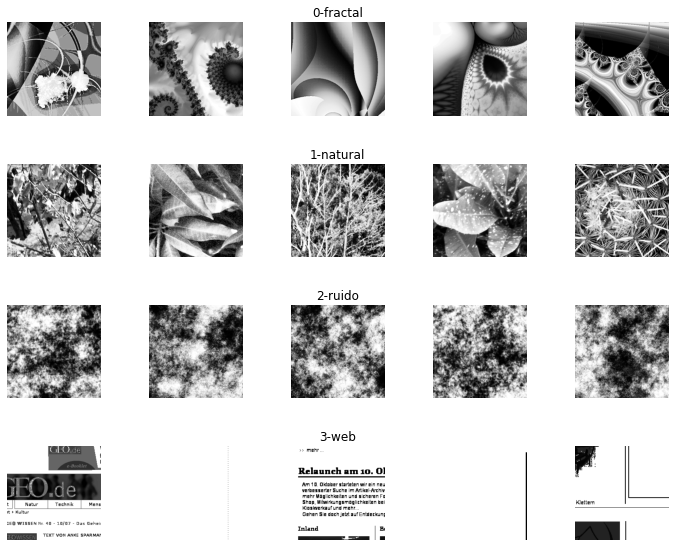

In [4]:
%%time

num_ejemplos = []
cols = 5
NB_CLASES = 4

fig, axs = plt.subplots(nrows = NB_CLASES, ncols = cols, figsize = (10, 8))
fig.tight_layout()
for i in range(cols):
    for j in range(NB_CLASES):
        x_selected = Xtrain[y_train==j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected-1)), :, :], cmap= plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i ==2:
            axs[j][i].set_title(str(j) + "-" + categorias[j])
            num_ejemplos.append(len(x_selected))

### Distribución del conjunto de entrenamiento

C:\Users\corvi\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


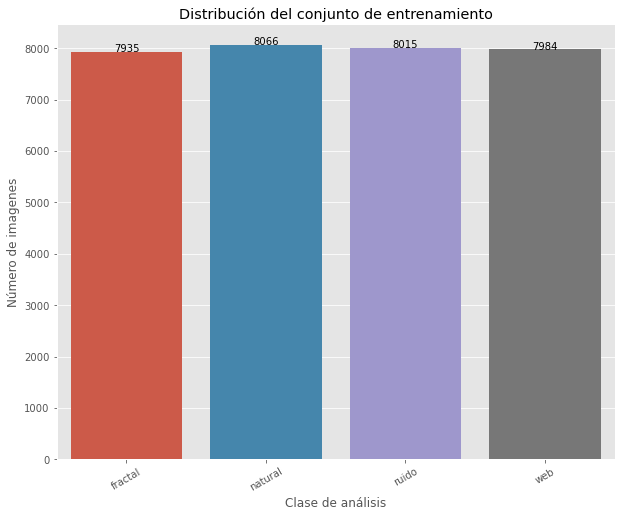

Wall time: 132 ms


In [5]:
%%time

df = pd.DataFrame({"categoria": categorias, "ejemplos": num_ejemplos}, columns= ["categoria", "ejemplos"])
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
g =sns.barplot(df["categoria"], df["ejemplos"])
for index, row in df.iterrows():
    g.text(row.name,row.ejemplos, round(row.ejemplos,2), color='black', ha="center")
plt.title("Distribución del conjunto de entrenamiento")
plt.xlabel("Clase de análisis")
plt.ylabel("Número de imagenes")
plt.xticks(rotation=30)
plt.show()

### Preprocesamiento de las imagenes

In [6]:
%%time

#normalizando los datos
train_scaled =np.zeros(Xtrain.shape[:3], dtype= "float32")
for i in range(Xtrain.shape[0]):
    train_scaled[i]=Xtrain[i]/255
    
test_scaled =np.zeros(Xtest.shape[:3], dtype= "float32")
for i in range(Xtest.shape[0]):
    test_scaled[i]=Xtest[i]/255
    
#Redimensionando
X_train = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[1], train_scaled.shape[2], 1)
X_test = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[1], test_scaled.shape[2], 1)
print(X_train.shape)
print(X_test.shape)

#Dummy de las etiquetas
y_train = to_categorical(y_train, len(categorias))
y_test = to_categorical(y_test, len(categorias))

(32000, 224, 224, 1)
(8000, 224, 224, 1)
Wall time: 5.18 s


### Modelo LeNet modificado

In [7]:
%%time

#Semilla
np.random.seed(322)

NB_EPOCAS = 40
BATCH_SIZE = 128
VERBOSE = 1
IMG_FILAS, IMG_COLS = 224, 224
OPTIMIZADOR = Adam(lr = 0.00005)
CONJ_VAL = 0.2
DROPOUT = 0.50

def LeNet_model():
    model = Sequential()
    model.add(Conv2D(20, (3, 3), input_shape=(IMG_FILAS, IMG_COLS, 1), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(40, (5, 5), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation = "relu"))
    model.add(Dropout(DROPOUT))
    model.add(Dense(NB_CLASES, activation = "softmax"))
    model.compile(OPTIMIZADOR, loss="categorical_crossentropy", metrics = ["accuracy"])
    return model

model = LeNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 20)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 40)      20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 40)        0         
_________________________________________________________________
flatten (Flatten)            (None, 112360)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               56180500  
_________________________________________________________________
dropout (Dropout)            (None, 500)               0

### Entrenando el modelo

Punto de control definido
Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.5229
Epoch 00001: val_loss improved from inf to 0.73098, saving model to D:/Documentos/modelos\img_5000.h5
200/200 [==============================] - 419s 2s/step - loss: 1.0749 - accuracy: 0.5229 - val_loss: 0.7310 - val_accuracy: 0.7869
Epoch 2/40
200/200 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.7470
Epoch 00002: val_loss improved from 0.73098 to 0.49616, saving model to D:/Documentos/modelos\img_5000.h5
200/200 [==============================] - 416s 2s/step - loss: 0.6497 - accuracy: 0.7470 - val_loss: 0.4962 - val_accuracy: 0.8673
Epoch 3/40
200/200 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.8304
Epoch 00003: val_loss improved from 0.49616 to 0.38049, saving model to D:/Documentos/modelos\img_5000.h5
200/200 [==============================] - 417s 2s/step - loss: 0.4760 - accuracy: 0.8304 - val_loss: 0.3805

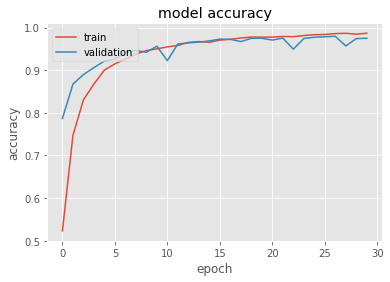

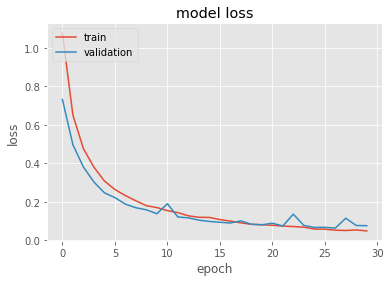

Wall time: 3h 31min 56s


In [8]:
%%time

#Definiendo el punto de control
filepath = "D:/Documentos/modelos/img_5000.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = VERBOSE,restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.2,patience = 3,verbose = 1,min_delta = 0.00001)

callbacks_list = [earlystop, checkpoint]
print("Punto de control definido")


#Estableciendo el modelo
history = model.fit(x = X_train, y =y_train, validation_split = CONJ_VAL, verbose = 1, batch_size = BATCH_SIZE, epochs = NB_EPOCAS, shuffle = "true", callbacks=callbacks_list)
 
#Resumen de la precisión del modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
 
#Resumen de la función de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluación del conjunto de prueba

In [9]:
score = model.evaluate(X_test, y_test, verbose = 1)
print("Conjunto de prueba. Función de perdida: ", score[0])
print("conjunto de prueba. Precisión: ", score[1])

250/250 [==============================] - 30s 122ms/step - loss: 0.0702 - accuracy: 0.9750
Conjunto de prueba. Función de perdida:  0.0701863020658493
conjunto de prueba. Precisión:  0.9750000238418579


### Matriz de confusión

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2065
           1       0.95      0.97      0.96      1934
           2       0.98      1.00      0.99      1985
           3       1.00      0.97      0.99      2016

    accuracy                           0.97      8000
   macro avg       0.98      0.98      0.97      8000
weighted avg       0.98      0.97      0.98      8000



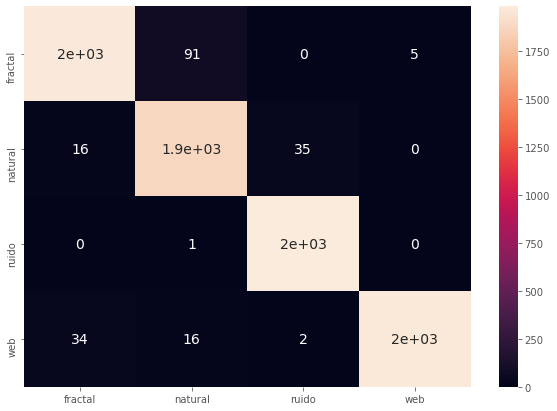

In [10]:
y_pred = model.predict_classes(X_test)

print(classification_report(np.argmax(y_test, axis=1), y_pred))
c = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
df = pd.DataFrame(c, index = categorias, columns = categorias)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True,annot_kws={"size": 14})
plt.show()